# Conformal Prediction Models

The following is a demonstration of the conformal prediciton models in Darts.

In [2]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd

from darts import concatenate, metrics
from darts.datasets import ElectricityConsumptionZurichDataset
from darts.models import ConformalNaiveModel, LinearRegressionModel

## Conformal Prediction for Time Series Forecasting

*Conformal prediction is a technique for constructing prediction intervals that try to achieve valid coverage in finite samples, without making distributional assumptions.* [(source)](https://arxiv.org/pdf/1905.03222)

In other words: If we want a prediction interval that includes 80% of all actual values over some period of time, then a conformal model attempts to generate such intervals that actually have 80% of points inside.

There are different techniques to perform conformal prediction. In Darts, we currently use **Split Conformal Prediciton [(SCP, Lei
et al., 2018)](https://www.stat.cmu.edu/~ryantibs/papers/conformal.pdf)** (with some nice adaptions) due to its simplicity and efficiency. 

### Split Conformal Prediction
SCP adds calibrated prediction intervals with a specified confidence level to a base model's forecasts. It involves splitting the data into a training (+ optional validation) set and a calibration (+ test) set. The model is trained on the training set, and the calibration set is used to compute the prediction intervals to ensure they contain the true values with the desired probability.

#### Advantages

- **Valid Coverage**: Provides valid prediction intervals that are guaranteed to contain the true value with a specified confidence level on finite samples.
- **Model-agnostic**: Can be applied to any predictive model:
  - Either adds calibrated prediction intervals to point forecasting models
  - Or calibrates the predicted intervals in case of probabilistic forecasting models
- **Distribution-free**: No distributional assumptions about the data except that the errors on the calibration set are exchangeable (e.g. we don't need to assume that our data is normally distributed and then fit a model with a `GaussianLikelihood`).
- **Efficient**: Split Conformal Prediciton is very efficient since it does not require model re-training.
- **Interpretable**: The method is interpretable due its simplicity.
- **Useful Applications**: It's used to provide more reliable and informative predictions to help decision making in several industry. See this [article on conformal prediction](https://medium.com/@data-overload/conformal-prediction-a-critic-to-predictive-models-27501dcc76d4)

#### Disadvantages

- **Requires a Calibration Set**: Conformal prediction requires another data / hold-out set that is used solely to compute the calibrated prediction intervals. This can be inefficient for small datasets.
- **Exchangeability of Calibration Data (*)**: The accuracy of the prediction intervals depends on the representativeness of the calibration data (or rather the forecast errors produced on the calibration set). The coverage is not guaranteed anymore if there is a **distribution shift** in forecast errors (e.g. series with a trend but forecasting model is not able to predict the trend).
- **Conservativeness (*)**: May produce wider intervals than necessary, leading to conservative predictions.

(*) Darts conformal models have some parameters to control the extraction of the calibration set for more adaptiveness.

## Darts Conformal Models

Darts' conformal models add calibrated prediciton intervals to the forecasts of any **pre-trained global forecasting model**. 
There is no need to train the conformal models themselves (e.g. no `fit()` requried) and you can directly call `predict()` or `historical_forecasts()`. Behind the hood, Darts will automatically extract the calibration set from the past of your input series and use it to generate the calibrated prediction intervals (see [here](#Workflow-behind-the-hood) for more detail).

> **Important**: The `series` passed to the forecast methods **should not have any overlap** with the series used to **train** the forecasting model, since this will lead to overly optimistic prediction intervals.

### Direct Interval Bound Predictions or Sampled Predictions
Conformal models are probabilistic, so you can forecast in two ways (when calling `predict()`, `historical_forecasts()`, ...):

- Forecast the calibrated quantile interval bounds directly (example [here](https://unit8co.github.io/darts/quickstart/00-quickstart.html#Direct-Parameter-Predicitons)).
  - `predict(..., predict_likelihood_parameters=True)`
- Generate stochastic forecasts by sampling from these calibrated quantile intervals (examples [here](https://unit8co.github.io/darts/quickstart/00-quickstart.html#Probabilistic-Sample-Predictions)):
  - `predict(..., num_samples=1000)`

### Model support

All conformal models in Darts support:

- any **pre-trained global forecasting model** as the base forecaster (you can find a list [here](https://unit8co.github.io/darts/#forecasting-models))
- **uni-** and **multivariate** forecasts (single / multi-columns)
- **single** and **multiple series** forecasts
- **single** and **multi-horizon** forecasts
- generate a **single** or **multiple calibrated prediction intervals**
- **direct quantile value** predictions (interval bounds) or **sampled predictions** from these quantile values
- **any covariates** based on the underlying forecasting model

### Workflow behind the hood

In general the workflow of the models to produce one calibrated forecast/prediction is as follows (using `predict()`):

- **Extract a calibration set**: The calibration set for each conformal forecast is automatically extracted from
  the past of your input series relative to the forecast start point. The number of calibration examples
  (forecast errors / non-conformity scores) to consider can be defined at model creation
  with parameter `cal_length`. Note that when using `cal_stride>1`, a longer history is required since
  the calibration examples are generated with stridden historical forecasts.
- Generate **historical forecasts** on the calibration set (using the forecasting model) with a stride `cal_stride`.
- Compute the **errors/non-conformity scores** (specific to each conformal model) on these historical forecasts
- Compute the **quantile values** from the errors / non-conformity scores (using our desired quantiles set at model
  creation with parameter `quantiles`).
- Compute the conformal prediction: Using these quantile values, add **calibrated intervals** to (or adjust the
  existing intervals of) the forecasting model's predictions.

For **multi-horizon forecasts**, the above is applied for each step in the horizon separately.

When computing `historical_forecasts()`, `backtest()`, `residuals()`, ... the above is applied for each forecast (the forecasting model's historical forecasts are only generated once for efficiency).


### Available Conformal Models

At the time of writing (Darts version 0.32.0), we have two conformal models:

#### `ConformalNaiveModel`

Adds calibrated intervals around the median forecast from **any pre-trained global forecasting model**. It supports two symmetry modes:

- `symmetric=True`:
    - The lower and upper interval bounds are calibrated with the same magnitude.
    - Non-conformity scores: uses the [absolute error `ae()`](https://unit8co.github.io/darts/generated_api/darts.metrics.metrics.html#darts.metrics.metrics.ae) to compute the non-conformity scores on the calibration set.
- `symmetric=False`
    - The lower and upper interval bounds are calibrated separately.
    - Non-conformity scores: uses the [error `err()`](https://unit8co.github.io/darts/generated_api/darts.metrics.metrics.html#darts.metrics.metrics.err) to compute the
      non-conformity scores on the calibration set for the upper bounds, and `-err()` for the lower bounds.

#### `ConformalQRModel` (Conformalized Quantile Regression Model)

Calibrates the quantile predictions from a **pre-trained probabilistic global forecasting model**. It supports two symmetry modes:

- `symmetric=True`:
    - The lower and upper quantile predictions are calibrated with the same magnitude.
    - Non-conformity scores: uses the [Non-Conformity Score for Quantile Regression `incs_qr(symmetric=True)`](https://unit8co.github.io/darts/generated_api/darts.metrics.metrics.html#darts.metrics.metrics.incs_qr) on the calibration set.
- `symmetric=False`
    - The lower and upper quantile predictions are calibrated separately.
    - Non-conformity scores: uses the [Asymmetric Non-Conformity Score for Quantile Regression `incs_qr(symmetric=False)`](https://unit8co.github.io/darts/generated_api/darts.metrics.metrics.html#darts.metrics.metrics.incs_qr) for the upper and lower bound on the calibration set.

### Input Dataset
For this notebook, we use the Electricity Consumption Dataset from households in Zurich, Switzerland.

The dataset has a quarter-hourly frequency (15 Min time intervals), but we resample it to hourly frequency to keep things simple.

To keep it simple, we will not use any covariates and only concentrate on the electricty consumption as the target we want to predict. The conformal model's covariate support and API is identical to the base-forecaster.

**Target series** (the series we want to forecast):
- **Value_NE5**: Electricity consumption by households on grid level 5 (in kWh).

<Axes: xlabel='Timestamp'>

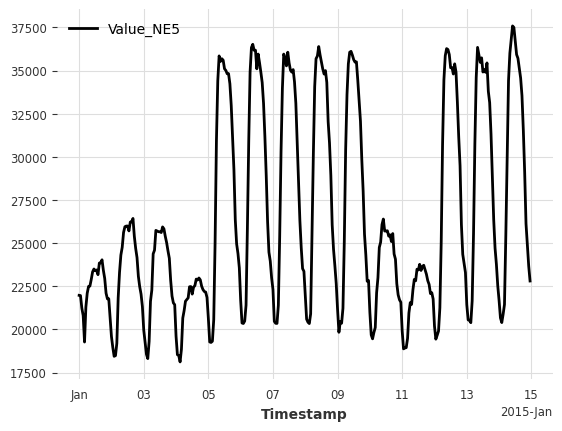

In [4]:
series = ElectricityConsumptionZurichDataset().load()

# extract target and resample to hourly frequency
series = series["Value_NE5"].resample(freq="h")

# plot 2 weeks of hourly consumption
series[: 2 * 7 * 24].plot()

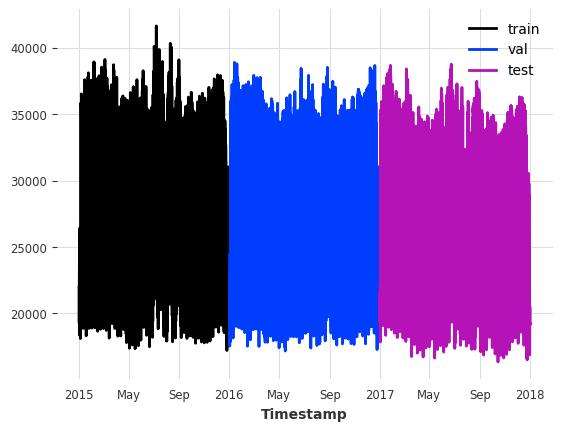

In [5]:
train_start = pd.Timestamp("2015-01-01")
cal_start = pd.Timestamp("2016-01-01")
test_start = pd.Timestamp("2017-01-01")
test_end = pd.Timestamp("2018-01-01")

train = series[train_start : cal_start - series.freq]
cal = series[cal_start : test_start - series.freq]
test = series[test_start:test_end]

train.plot(label="train")
cal.plot(label="val")
test.plot(label="test");

### Train the base forecaster

Let's use a `LinearRegressionModel` as our base forecasting model. We'll configure it to use the last 24 hours as lookback to forecast the next 24 hours.

- train it on the `train` set
- forecast the next 24 hours after the end of the `cal` set

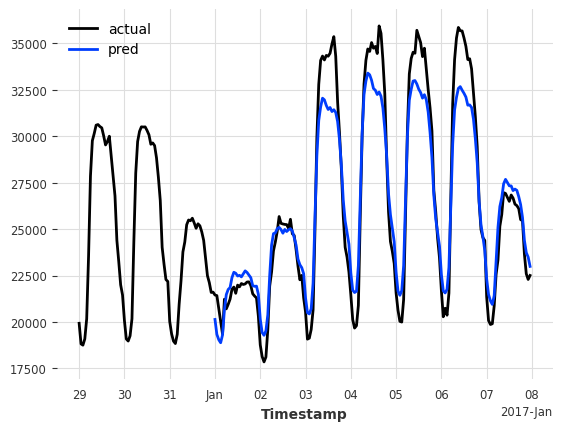

In [8]:
input_length = 7 * 24
horizon = 7 * 24

# train the model
model = LinearRegressionModel(lags=input_length, output_chunk_length=horizon)
model.fit(train)

# forecast and plot
pred = model.predict(n=horizon, series=cal)
series[pred.start_time() - 3 * 24 * series.freq : pred.end_time()].plot(label="actual")
pred.plot(label="pred");

We can clearly see that the forecasts are off. But we have no estiamte of the uncertainty.

### Apply Conformal Prediction

Now let's apply conformal prediciton to quantify the uncertainty. We use the symmetric (default) naive model including the quantile levels we want to forecast. Let's:

- we don't need to train / fit the conformal model
- we should supply a `series` to `predict()` that does not have an overlap with the series used to train the model. In our case `cal` has no overlap with `train`.

Let's add the 90% (quantiles 0.05 - 0.95) and 80% (0.10 - 0.90) prediction intervals.

historical forecasts:   0%|          | 0/1 [00:00<?, ?it/s]

conformal forecasts:   0%|          | 0/1 [00:00<?, ?it/s]

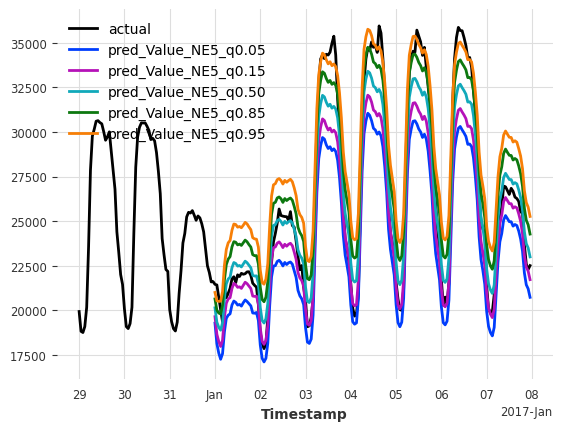

In [9]:
quantiles = [0.05, 0.15, 0.50, 0.85, 0.95]
pred_kwargs = {"predict_likelihood_parameters": True, "verbose": True}


cp_model = ConformalNaiveModel(
    model=model,
    quantiles=quantiles,
    symmetric=True,  # default, whether to
    cal_stride=1,  # default, stride to apply to historical forecasts on calibration set
)

pred = cp_model.predict(n=horizon, series=cal, **pred_kwargs)
series[pred.start_time() - 3 * 24 * series.freq : pred.end_time()].plot(label="actual")
pred.plot(label="pred");

Great, we can see the two added prediction intervals. Most of the actuals seem to be within the 90% interval.
Let's look at how to evaluate this forecast.

> **Note about computational time**: In this case the time to produce the conformal forecast is dominated by the historical forecasts (4 seconds) on the calibration set. Behind the hood the model computed a backtest over an entire year (generating and evaluating more than 200k predictions; 8'760 1-day forecasts using 24 dedicated linear models (one for each horizon)). The performance can be greatly improved by adjusting `cal_length` and `cal_stride` at conformal model creation (more on that later).

### Evaluate Conformal Prediction

Darts has dedicated metrics for prediction intervals. You can find them on [our metrics page](https://unit8co.github.io/darts/generated_api/darts.metrics.html) under the *Quantile interval metrics*

- `(m)ic`: (Mean) Interval Coverage
- `(m)iw`: (Mean) Interval Width
- `(m)iws`: (Mean) Interval Winkler Score
- `(m)incs_qr`: (Mean) Interval Non-Conformity Score for Quantile Regression

Let's check the mean interval coverage (the ratio of actual values being within each interval) and the interval width:

In [10]:
q_interval = cp_model.q_interval  # [(0.05, 0.95), (0.10, 0.90)]
q_range = cp_model.interval_range  # [0.9, 0.8]


def compute_metric(pred_, metric=metrics.mic, name="Coverage"):
    mic = metric(series, pred_, q_interval=q_interval)
    return pd.DataFrame({"Interval": q_range, f"Predicted {name}": mic}).round(2)


compute_metric(pred)

,Interval,Predicted Coverage
0,0.9,0.85
1,0.7,0.58


Okay that doesn't look great for the coverage of the 0.8 interval. But we only looked at 1 example. How does it perform on the entire test set?

In [12]:
cal_test = concatenate([cal, test], axis=0)
hfcs = cp_model.historical_forecasts(
    series=cal_test,
    forecast_horizon=horizon,
    start=test.start_time(),
    last_points_only=False,
    stride=horizon,
    **pred_kwargs,
)

historical forecasts:   0%|          | 0/1 [00:00<?, ?it/s]

OutOfBoundsDatetime: Cannot generate range with start=1452211200000000000 and periods=2891280

<Axes: xlabel='Timestamp'>

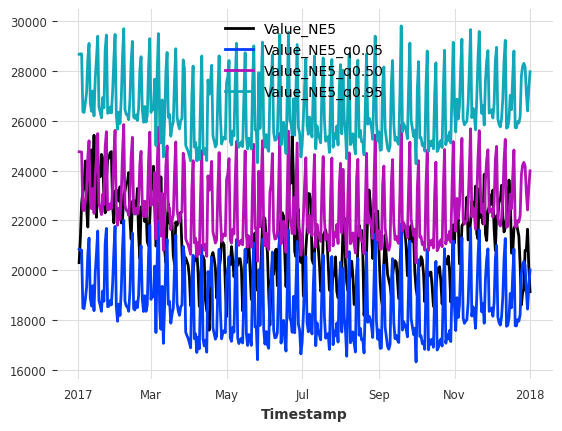

In [41]:
test[hfcs.start_time() :: horizon].plot()
hfcs.plot()

In [42]:
cp_model.backtest(
    cal_test,
    historical_forecasts=hfcs,
    last_points_only=True,
    metric=[metrics.mic, metrics.miw],
    metric_kwargs={"q_interval": q_interval},
)

array([8.68493151e-01, 7.84759801e+03])

<Axes: xlabel='Timestamp'>

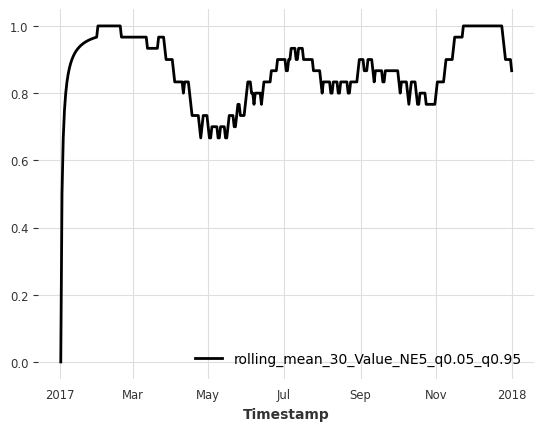

In [52]:
cp_model.residuals(
    cal_test,
    historical_forecasts=hfcs,
    last_points_only=True,
    metric=metrics.ic,
    metric_kwargs={"q_interval": q_interval},
).window_transform(
    transforms={"function": "mean", "mode": "rolling", "window": 30}
).plot()

In [ ]:
cp_model

historical forecasts:   0%|          | 0/1 [00:00<?, ?it/s]

conformal forecasts:   0%|          | 0/1 [00:00<?, ?it/s]

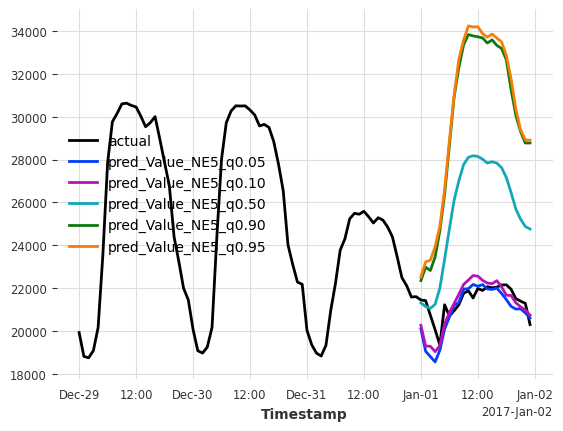

In [53]:
quantiles = [0.05, 0.1, 0.5, 0.9, 0.95]
cp_model = ConformalNaiveModel(
    model=model, quantiles=quantiles, cal_stride=7 * 24, cal_length=52
)

pred = cp_model.historical_forecasts(
    n=horizon,
    series=concatenate([cal, test], axis=0),
    cal_stride=24,
    verbose=True,
    predict_likelihood_parameters=True,
)
series[pred.start_time() - 3 * 24 * series.freq : pred.end_time()].plot(label="actual")
pred.plot(label="pred");

## Sources

(1) Lei, J., G’Sell, M., Rinaldo, A., Tibshirani, R. J., and Wasserman, L. (2018). Distribution-Free Predictive Inference
for Regression. Journal of the American Statistical Association, 113(523):1094–1111.